In [129]:
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import pyfolio as pf
import datetime
import hvplot.pandas
import numpy as np

%matplotlib inline

In [50]:
load_dotenv()

True

In [62]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca tradeapi.REST object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [114]:
tickers = ['LOW', 'CMG', 'QSR', 'HLT', 'HHC', 'AAPL', 'BAC', 'KO', 'CVX', 'AXP', 'SPY', 'PG', 'VTSAX', 'PEP', 'JNJ', 'TSLA', 'TDOC', 'AMZN']

In [115]:
# Set timeframe to 1Day
# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
timeframe = "1Day"
start_date = pd.Timestamp("2017-08-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-08-01", tz="America/New_York").isoformat()

In [116]:
ticker_data = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
).df

In [117]:
ticker_data

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-08-01 04:00:00+00:00,149.27,150.2200,148.4100,150.05,35380897,223054,151.670075,AAPL
2017-08-02 04:00:00+00:00,159.50,159.7500,156.1600,157.14,69957154,398107,157.903553,AAPL
2017-08-03 04:00:00+00:00,157.03,157.2100,155.0200,155.57,27097408,166577,155.916894,AAPL
2017-08-04 04:00:00+00:00,156.12,157.4000,155.6900,156.39,20559852,130145,156.445418,AAPL
2017-08-07 04:00:00+00:00,157.00,158.9200,156.6701,158.81,21871327,129566,158.015841,AAPL
...,...,...,...,...,...,...,...,...
2022-07-26 04:00:00+00:00,799.50,801.9299,768.7900,776.58,22273586,551723,782.001569,TSLA
2022-07-27 04:00:00+00:00,791.50,827.7768,785.3701,824.46,29275547,669212,811.026306,TSLA
2022-07-28 04:00:00+00:00,840.05,849.9000,818.4000,842.70,28240997,700681,837.389749,TSLA


In [119]:
ticker_data_pivoted = ticker_data.pivot(columns='symbol', values=['close', 'open']
)
ticker_data_pivoted.head()

close                                        \
symbol                       AAPL    AMZN    AXP    BAC     CMG     CVX   
timestamp                                                                 
2017-08-01 04:00:00+00:00  150.05  996.19  85.24  24.45  347.24  110.78   
2017-08-02 04:00:00+00:00  157.14  995.89  85.30  24.59  351.06  110.46   
2017-08-03 04:00:00+00:00  155.57  986.92  85.54  24.37  345.36  109.43   
2017-08-04 04:00:00+00:00  156.39  987.58  85.97  24.97  344.56  110.11   
2017-08-07 04:00:00+00:00  158.81  992.27  85.85  24.96  339.45  109.78   

                                                         ...   open          \
symbol                        HHC    HLT     JNJ     KO  ...    HLT     JNJ   
timestamp                                                ...                  
2017-08-01 04:00:00+00:00  125.91  62.77  132.51  45.70  ...  62.88  133.17   
2017-08-02 04:00:00+00:00  126.01  61.98  132.16  45.59  ...  62.69  132.08   
2017-08-03 04:00:00+00:00  126.09  62.13  133.35  45.67  ...  62.10  131.88   
2017-08-04 04:00:00+00:00  125.41  62.98  133.18  45.50  ...  62.31  133.74   
2017-08-07 04:00:00+00:00  125.77  63.77  132.86  45.64  ...  63.34  133.09   

                                                                             \
symbol                        KO    LOW     PEP     PG    QSR     SPY  TDOC   
timestamp                                                                     
2017-08-01 04:00:00+00:00  45.97  77.41  116.69  91.00  59.95  247.45  32.9   
2017-08-02 04:00:00+00:00  45.56  77.57  115.73  90.97  58.15  247.47  32.5   
2017-08-03 04:00:00+00:00  45.67  78.07  115.73  90.96  60.40  247.31  31.0   
2017-08-04 04:00:00+00:00  45.67  78.46  116.32  90.70  61.27  247.52  30.5   
2017-08-07 04:00:00+00:00  45.52  78.50  116.45  90.65  62.29  247.50  30.8   

                                   
symbol                       TSLA  
timestamp                          
2017-08-01 04:00:00+00:00  322.69  
2017-08-02 04:00:00+00:00  318.94  
2017-08-03 04:00:00+00:00  346.80  
2017-08-04 04:00:00+00:00  347.00  
2017-08-07 04:00:00+00:00  357.00  

[5 rows x 34 columns]

In [120]:
ticker_data_pivoted = ticker_data_pivoted.fillna(0)
ticker_data_pivoted.head()

close                                        \
symbol                       AAPL    AMZN    AXP    BAC     CMG     CVX   
timestamp                                                                 
2017-08-01 04:00:00+00:00  150.05  996.19  85.24  24.45  347.24  110.78   
2017-08-02 04:00:00+00:00  157.14  995.89  85.30  24.59  351.06  110.46   
2017-08-03 04:00:00+00:00  155.57  986.92  85.54  24.37  345.36  109.43   
2017-08-04 04:00:00+00:00  156.39  987.58  85.97  24.97  344.56  110.11   
2017-08-07 04:00:00+00:00  158.81  992.27  85.85  24.96  339.45  109.78   

                                                         ...   open          \
symbol                        HHC    HLT     JNJ     KO  ...    HLT     JNJ   
timestamp                                                ...                  
2017-08-01 04:00:00+00:00  125.91  62.77  132.51  45.70  ...  62.88  133.17   
2017-08-02 04:00:00+00:00  126.01  61.98  132.16  45.59  ...  62.69  132.08   
2017-08-03 04:00:00+00:00  126.09  62.13  133.35  45.67  ...  62.10  131.88   
2017-08-04 04:00:00+00:00  125.41  62.98  133.18  45.50  ...  62.31  133.74   
2017-08-07 04:00:00+00:00  125.77  63.77  132.86  45.64  ...  63.34  133.09   

                                                                             \
symbol                        KO    LOW     PEP     PG    QSR     SPY  TDOC   
timestamp                                                                     
2017-08-01 04:00:00+00:00  45.97  77.41  116.69  91.00  59.95  247.45  32.9   
2017-08-02 04:00:00+00:00  45.56  77.57  115.73  90.97  58.15  247.47  32.5   
2017-08-03 04:00:00+00:00  45.67  78.07  115.73  90.96  60.40  247.31  31.0   
2017-08-04 04:00:00+00:00  45.67  78.46  116.32  90.70  61.27  247.52  30.5   
2017-08-07 04:00:00+00:00  45.52  78.50  116.45  90.65  62.29  247.50  30.8   

                                   
symbol                       TSLA  
timestamp                          
2017-08-01 04:00:00+00:00  322.69  
2017-08-02 04:00:00+00:00  318.94  
2017-08-03 04:00:00+00:00  346.80  
2017-08-04 04:00:00+00:00  347.00  
2017-08-07 04:00:00+00:00  357.00  

[5 rows x 34 columns]

In [121]:
ticker_daily_returns_df = ticker_data_pivoted["close"].pct_change().fillna(0)
ticker_daily_returns_df.head()

symbol,AAPL,AMZN,AXP,BAC,CMG,CVX,HHC,HLT,JNJ,KO,LOW,PEP,PG,QSR,SPY,TDOC,TSLA
timestamp,,,,,,,,,,,,,,,,,
2017-08-01 04:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08-02 04:00:00+00:00,0.047251,-0.000301,0.000704,0.005726,0.011001,-0.002889,0.000794,-0.012586,-0.002641,-0.002407,0.000385,-0.002674,-0.000659,0.007426,0.000485,-0.055300,0.019777
2017-08-03 04:00:00+00:00,-0.009991,-0.009007,0.002814,-0.008947,-0.016237,-0.009325,0.000635,0.002420,0.009004,0.001755,0.000642,0.005968,-0.001977,0.016753,-0.001940,-0.016260,0.065053
2017-08-04 04:00:00+00:00,0.005271,0.000669,0.005027,0.024620,-0.002316,0.006214,-0.005393,0.013681,-0.001275,-0.003722,0.005904,0.000602,-0.002091,0.023398,0.001822,0.021488,0.028292
2017-08-07 04:00:00+00:00,0.015474,0.004749,-0.001396,-0.000400,-0.014831,-0.002997,0.002871,0.012544,-0.002403,0.003077,-0.000638,0.005070,0.008492,0.000805,0.001859,0.025890,-0.004875


<AxesSubplot:title={'center':'Ticker PCT Change'}, xlabel='timestamp'>

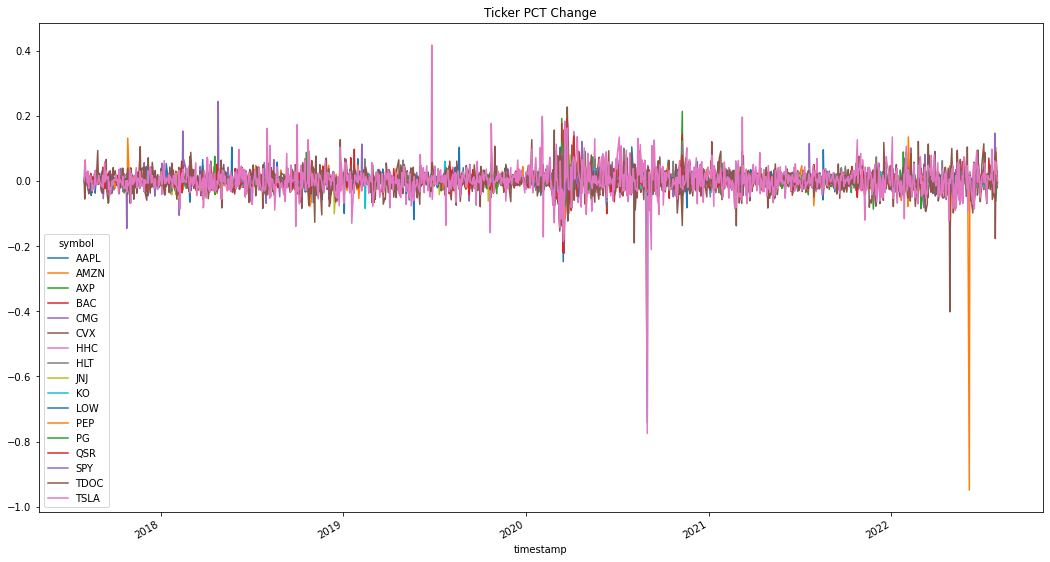

In [123]:
ticker_daily_returns_df.plot( title="Ticker PCT Change", figsize = (18,10))

In [124]:
cumulative_returns_df = (1 + ticker_daily_returns_df).cumprod()
cumulative_returns_df.tail()

symbol,AAPL,AMZN,AXP,BAC,CMG,CVX,HHC,HLT,JNJ,KO,LOW,PEP,PG,QSR,SPY,TDOC,TSLA
timestamp,,,,,,,,,,,,,,,,,
2022-07-26 04:00:00+00:00,1.010330,0.115249,1.757743,1.351738,3.791124,1.329843,0.554444,1.915246,1.310694,1.383151,2.423230,1.482315,1.583644,0.858228,1.580503,1.234716,2.430078
2022-07-27 04:00:00+00:00,1.044918,0.121433,1.778860,1.373824,4.348577,1.347355,0.566436,2.059105,1.307071,1.378775,2.440190,1.480245,1.598683,0.878481,1.621543,1.328418,2.579904
2022-07-28 04:00:00+00:00,1.048650,0.122748,1.784843,1.362781,4.431747,1.357556,0.567548,2.039191,1.314618,1.401751,2.451497,1.508282,1.625247,0.896540,1.641881,1.093702,2.636981
2022-07-29 04:00:00+00:00,1.083039,0.135466,1.806898,1.382822,4.504723,1.478426,0.563021,2.040306,1.317033,1.404158,2.460876,1.509317,1.524808,0.904810,1.665818,1.132104,2.789530
2022-08-01 04:00:00+00:00,1.076375,0.135908,1.798803,1.378732,4.485025,1.448908,0.556588,2.050183,1.312429,1.411816,2.493768,1.526484,1.568606,0.919156,1.660885,1.130876,2.790719


<AxesSubplot:title={'center':'Ticker Cumulative Returns'}, xlabel='timestamp'>

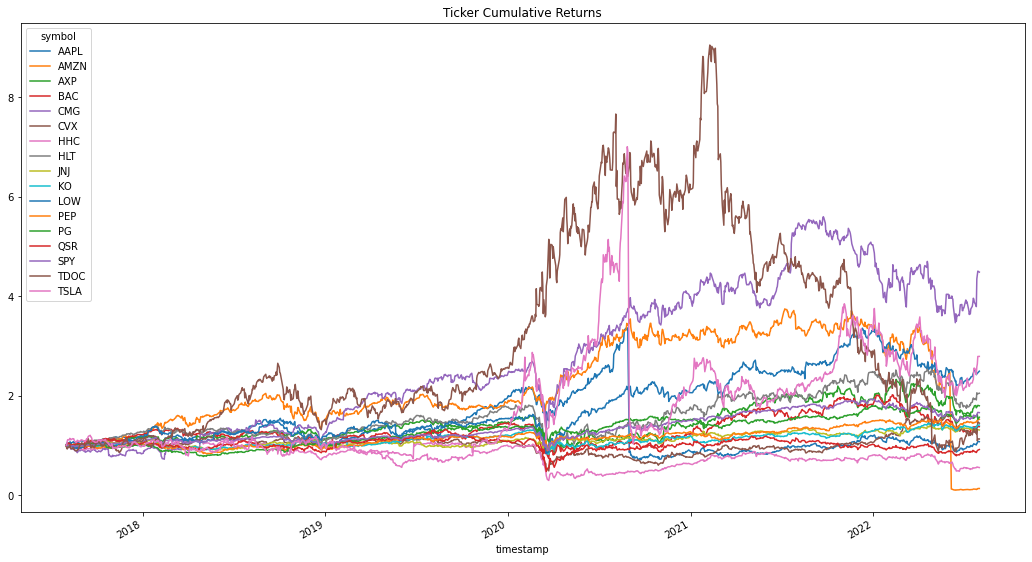

In [125]:
cumulative_returns_df.plot( title="Ticker Cumulative Returns", figsize = (18,10))

In [127]:
tickers_daily_std = ticker_daily_returns_df.std().sort_values()
tickers_daily_std

symbol
SPY     0.012947
JNJ     0.013026
KO      0.013363
PG      0.013585
PEP     0.013748
QSR     0.020041
LOW     0.020808
HLT     0.021258
BAC     0.021938
CVX     0.021939
AXP     0.023042
CMG     0.024780
HHC     0.027179
AAPL    0.029130
AMZN    0.034339
TDOC    0.039562
TSLA    0.045636
dtype: float64

In [130]:
tickers_daily_std_annualized = tickers_daily_std * np.sqrt(252)
tickers_daily_std_annualized

symbol
SPY     0.205531
JNJ     0.206789
KO      0.212133
PG      0.215653
PEP     0.218236
QSR     0.318136
LOW     0.330321
HLT     0.337467
BAC     0.348256
CVX     0.348276
AXP     0.365780
CMG     0.393376
HHC     0.431461
AAPL    0.462431
AMZN    0.545118
TDOC    0.628034
TSLA    0.724444
dtype: float64

<AxesSubplot:title={'center':'21 Day Rolling Standard Deviations'}, xlabel='timestamp'>

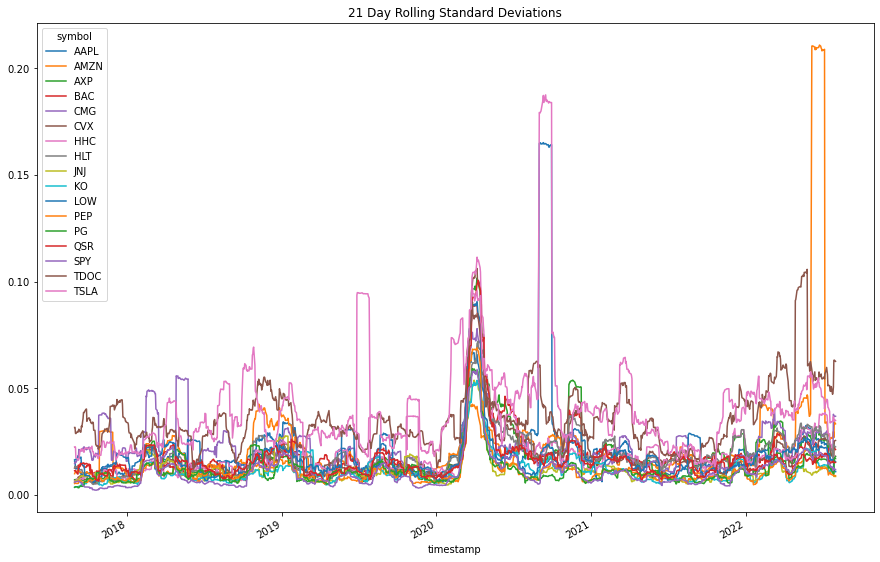

In [131]:
tickers_daily_rolling_std_dev = ticker_daily_returns_df.rolling(window=21).std()
tickers_daily_rolling_std_dev.plot(figsize=(15,10), title="21 Day Rolling Standard Deviations")

In [132]:
annual_average_return = ticker_daily_returns_df.mean() * 252
annual_average_return.sort_values()

symbol
HHC    -0.026725
QSR     0.034071
AMZN    0.064481
JNJ     0.075864
KO      0.091696
PEP     0.108547
PG      0.113319
SPY     0.122815
BAC     0.124701
CVX     0.135428
AXP     0.183382
AAPL    0.189009
HLT     0.200605
TDOC    0.228242
LOW     0.238790
CMG     0.376587
TSLA    0.550344
dtype: float64

In [133]:
sharpe_ratio = annual_average_return / tickers_daily_std_annualized
sharpe_ratio.sort_values()

symbol
HHC    -0.061941
QSR     0.107096
AMZN    0.118288
BAC     0.358074
TDOC    0.363424
JNJ     0.366869
CVX     0.388854
AAPL    0.408729
KO      0.432256
PEP     0.497384
AXP     0.501345
PG      0.525469
HLT     0.594443
SPY     0.597549
LOW     0.722903
TSLA    0.759678
CMG     0.957321
dtype: float64

In [136]:
sharpe_ratio.hvplot.bar(title = "Sharpe Ratios")

:Bars   [symbol]   (0)

In [141]:
tickers_rolling_var = ticker_daily_returns_df.loc[:, "SPY"].rolling(window=60).var().dropna()
tickers_rolling_var.head()

timestamp
2017-10-24 04:00:00+00:00    0.000019
2017-10-25 04:00:00+00:00    0.000019
2017-10-26 04:00:00+00:00    0.000019
2017-10-27 04:00:00+00:00    0.000020
2017-10-30 04:00:00+00:00    0.000021
Name: SPY, dtype: float64

In [144]:
tickers_rolling_covariance =ticker_daily_returns_df.rolling(window=60).cov().dropna()
tickers_rolling_covariance

symbol                                AAPL      AMZN       AXP       BAC  \
timestamp                 symbol                                           
2017-10-24 04:00:00+00:00 AAPL    0.000150  0.000062  0.000033  0.000061   
                          AMZN    0.000062  0.000095  0.000021  0.000056   
                          AXP     0.000033  0.000021  0.000048  0.000054   
                          BAC     0.000061  0.000056  0.000054  0.000160   
                          CMG     0.000039  0.000061  0.000024  0.000054   
...                                    ...       ...       ...       ...   
2022-08-01 04:00:00+00:00 PG      0.000163  0.000129  0.000110  0.000101   
                          QSR     0.000298  0.000442  0.000290  0.000195   
                          SPY     0.000380  0.000450  0.000341  0.000265   
                          TDOC    0.000911  0.001401  0.000776  0.000569   
                          TSLA    0.000942  0.001009  0.000797  0.000548   

symbol                                 CMG       CVX       HHC       HLT  \
timestamp                 symbol                                           
2017-10-24 04:00:00+00:00 AAPL    0.000039  0.000011  0.000004  0.000012   
                          AMZN    0.000061  0.000011  0.000021  0.000034   
                          AXP     0.000024  0.000003  0.000009  0.000020   
                          BAC     0.000054  0.000024  0.000019  0.000043   
                          CMG     0.000354  0.000050  0.000048  0.000031   
...                                    ...       ...       ...       ...   
2022-08-01 04:00:00+00:00 PG      0.000146 -0.000017  0.000179  0.000097   
                          QSR     0.000380  0.000144  0.000386  0.000326   
                          SPY     0.000414  0.000233  0.000409  0.000374   
                          TDOC    0.001156  0.000289  0.001116  0.001032   
                          TSLA    0.001017  0.000446  0.000851  0.000862   

symbol                                 JNJ        KO       LOW       PEP  \
timestamp                 symbol                                           
2017-10-24 04:00:00+00:00 AAPL    0.000012  0.000003 -0.000003  0.000019   
                          AMZN    0.000012  0.000004  0.000016  0.000015   
                          AXP     0.000002  0.000003 -0.000003  0.000006   
                          BAC    -0.000006 -0.000008  0.000010 -0.000006   
                          CMG     0.000022  0.000015  0.000048  0.000020   
...                                    ...       ...       ...       ...   
2022-08-01 04:00:00+00:00 PG      0.000114  0.000190  0.000135  0.000184   
                          QSR     0.000060  0.000112  0.000195  0.000109   
                          SPY     0.000087  0.000137  0.000239  0.000139   
                          TDOC    0.000144  0.000136  0.000706  0.000183   
                          TSLA    0.000101  0.000165  0.000569  0.000232   

symbol                                  PG       QSR       SPY      TDOC  \
timestamp                 symbol                                           
2017-10-24 04:00:00+00:00 AAPL    0.000014  0.000030  0.000029  0.000008   
                          AMZN    0.000009  0.000043  0.000029  0.000063   
                          AXP     0.000004  0.000010  0.000017 -0.000007   
                          BAC    -0.000019  0.000035  0.000038  0.000063   
                          CMG     0.000007  0.000001  0.000021  0.000012   
...                                    ...       ...       ...       ...   
2022-08-01 04:00:00+00:00 PG      0.000317  0.000115  0.000129  0.000121   
                          QSR     0.000115  0.000282  0.000231  0.000537   
                          SPY     0.000129  0.000231  0.000293  0.000662   
                          TDOC    0.000121  0.000537  0.000662  0.003430   
                          TSLA    0.000146  0.000511  0.000653  0.001766   

symbol                                TSLA  

In [148]:
spy_rolling_var = ticker_daily_returns_df.loc[:, "SPY"].rolling(window=60).var().dropna()
spy_rolling_var

timestamp
2017-10-24 04:00:00+00:00    0.000019
2017-10-25 04:00:00+00:00    0.000019
2017-10-26 04:00:00+00:00    0.000019
2017-10-27 04:00:00+00:00    0.000020
2017-10-30 04:00:00+00:00    0.000021
                               ...   
2022-07-26 04:00:00+00:00    0.000313
2022-07-27 04:00:00+00:00    0.000303
2022-07-28 04:00:00+00:00    0.000305
2022-07-29 04:00:00+00:00    0.000308
2022-08-01 04:00:00+00:00    0.000293
Name: SPY, Length: 1200, dtype: float64

In [150]:
beta_tickers_60 = tickers_rolling_covariance / spy_rolling_var
beta_tickers_60.head()


2017-10-24 04:00:00+00:00  \
timestamp                 symbol                              
2017-10-24 04:00:00+00:00 AAPL                          NaN   
                          AMZN                          NaN   
                          AXP                           NaN   
                          BAC                           NaN   
                          CMG                           NaN   

                                  2017-10-25 04:00:00+00:00  \
timestamp                 symbol                              
2017-10-24 04:00:00+00:00 AAPL                          NaN   
                          AMZN                          NaN   
                          AXP                           NaN   
                          BAC                           NaN   
                          CMG                           NaN   

                                  2017-10-26 04:00:00+00:00  \
timestamp                 symbol                              
2017-10-24 04:00:00+00:00 AAPL                          NaN   
                          AMZN                          NaN   
                          AXP                           NaN   
                          BAC                           NaN   
                          CMG                           NaN   

                                  2017-10-27 04:00:00+00:00  \
timestamp                 symbol                              
2017-10-24 04:00:00+00:00 AAPL                          NaN   
                          AMZN                          NaN   
                          AXP                           NaN   
                          BAC                           NaN   
                          CMG                           NaN   

                                  2017-10-30 04:00:00+00:00  \
timestamp                 symbol                              
2017-10-24 04:00:00+00:00 AAPL                          NaN   
                          AMZN                          NaN   
                          AXP                           NaN   
                          BAC                           NaN   
                          CMG                           NaN   

                                  2017-10-31 04:00:00+00:00  \
timestamp                 symbol                              
2017-10-24 04:00:00+00:00 AAPL                          NaN   
                          AMZN                          NaN   
                          AXP                           NaN   
                          BAC                           NaN   
                          CMG                           NaN   

                                  2017-11-01 04:00:00+00:00  \
timestamp                 symbol                              
2017-10-24 04:00:00+00:00 AAPL                          NaN   
                          AMZN                          NaN   
                          AXP                           NaN   
                          BAC                           NaN   
                          CMG                           NaN   

                                  2017-11-02 04:00:00+00:00  \
timestamp                 symbol                              
2017-10-24 04:00:00+00:00 AAPL                          NaN   
                          AMZN                          NaN   
                          AXP                           NaN   
                          BAC                           NaN   
                          CMG                           NaN   

                                  2017-11-03 04:00:00+00:00  \
timestamp                 symbol                              
2017-10-24 04:00:00+00:00 AAPL                          NaN   
                          AMZN                          NaN   
                          AXP                           NaN   
                          BAC                           NaN   
                          CMG                           NaN   

                                  2017-11-06 05:00:00+00